In [1]:
#先引入后面可能用到的包（package）
import pandas as pd  
import numpy as np
from scipy import stats
import tushare as ts 
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
#使用之前先输入token，可以从个人主页上复制出来，每次调用数据需要先运行该命令
token='e0eeb08befd1f07516df2cbf9cbd58663f77fd72f92a04f290291c9d'
ts.set_token(token)
pro=ts.pro_api()

In [3]:
df = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
print(len(df))
df.head()

3594


ts_code  symbol  name area industry list_date
0  000001.SZ  000001  平安银行   深圳       银行  19910403
1  000002.SZ  000002   万科A   深圳     全国地产  19910129
2  000004.SZ  000004  国农科技   深圳     生物制药  19910114
3  000005.SZ  000005  世纪星源   深圳     环境保护  19901210
4  000006.SZ  000006  深振业A   深圳     区域地产  19920427

In [4]:
#排除掉新股次新股，这里是只考虑2017年1月1日以前上市的股票
df=df[df['list_date'].apply(int).values<20170101]
len(df)

3024

In [5]:
#获取当前所有非新股次新股代码和名称
codes=df.ts_code.values
names=df.name.values
#构建一个字典方便调用
code_name=dict(zip(names,codes))

In [6]:
#使用tushare获取上述股票周价格数据并转换为周收益率
#设定默认起始日期为2018年1月5日，结束日期为2019年3月15日
#日期可以根据需要自己改动
def get_data(code,start='20180101', end='20190319'):
    df=pro.daily(ts_code=code, start_date=start, end_date=end,fields='trade_date,close')
    #将交易日期设置为索引值
    df.index=pd.to_datetime(df.trade_date)
    df=df.sort_index()
    #计算收益率
    return df.close

In [7]:
#构建一个空的dataframe用来装数据
data=pd.DataFrame()
for name,code in code_name.items():
    data[name]=get_data(code)

In [21]:
#data.to_csv('daily_data.csv',encoding='gbk')
#data=pd.read_csv('stock_data.csv',encoding='gbk',index_col='trade_date')
#data.index=(pd.to_datetime(data.index)).strftime('%Y%m%d')

In [8]:
#data.head()

In [9]:
#计算收益率
def cal_ret(df,w=5):
    '''w为时间周期，默认5日，周5;月20;半年：120; 一年250
    '''
    df=df/df.shift(w)-1
    return df.iloc[w:,:].fillna(0)

In [10]:
#计算120日累计收益率
ret120=cal_ret(data,w=120)
ret120.head()

平安银行       万科A      国农科技      世纪星源  深振业A  全新好  神州高铁      中国宝安  \
trade_date                                                                      
2018-07-03 -0.367153 -0.280713 -0.133841 -0.321759   0.0  0.0   0.0 -0.333333   
2018-07-04 -0.354089 -0.288586 -0.192857 -0.313817   0.0  0.0   0.0 -0.354447   
2018-07-05 -0.350943 -0.304046 -0.179002 -0.333333   0.0  0.0   0.0 -0.382199   
2018-07-06 -0.348872 -0.332278 -0.178602 -0.338710   0.0  0.0   0.0 -0.374834   
2018-07-09 -0.303241 -0.332870 -0.175131 -0.336384   0.0  0.0   0.0 -0.353723   

                美丽生态      深物业A    ...     兆易创新       康德莱      中电电机      艾华集团  \
trade_date                        ...                                          
2018-07-03 -0.279197 -0.388759    ...      0.0 -0.152835 -0.701257 -0.439937   
2018-07-04 -0.282098 -0.368728    ...      0.0 -0.169130 -0.725536 -0.451688   
2018-07-05 -0.293796 -0.409913    ...      0.0 -0.196094 -0.731160 -0.496655   
2018-07-06 -0.297872 -0.433426    ...      0.0 -0.177778 -0.730435 -0.491305   
2018-07-09 -0.351613 -0.425615    ...      0.0 -0.100083 -0.711864 -0.471572   

                麦迪科技      洛阳钼业      中新科技  继峰股份      方盛制药      读者传媒  
trade_date                                                          
2018-07-03 -0.075908 -0.113833 -0.357572   0.0 -0.234501 -0.236200  
2018-07-04 -0.089090 -0.143262 -0.351558   0.0 -0.256250 -0.247119  
2018-07-05 -0.095785 -0.224066 -0.409241   0.0 -0.351282 -0.264175  
2018-07-06 -0.107220 -0.210894 -0.389532   0.0 -0.355844 -0.280410  
2018-07-09 -0.137007 -0.204110 -0.359620   0.0 -0.298456 -0.258065  

[5 rows x 3024 columns]

In [11]:
#计算RPS
def get_RPS(ser):
    df=pd.DataFrame(ser.sort_values(ascending=False))
    df['n']=range(1,len(df)+1)
    df['rps']=(1-df['n']/len(df))*100
    return df
#计算每个交易日所有股票滚动w日的RPS
def all_RPS(data):
    dates=(data.index).strftime('%Y%m%d')
    RPS={}
    for i in range(len(data)):
        RPS[dates[i]]=pd.DataFrame(get_RPS(data.iloc[i]).values,columns=['收益率','排名','RPS'],index=get_RPS(data.iloc[i]).index)  
    return RPS  

In [12]:
rps120=all_RPS(ret120)

In [13]:
#查看2019年3月19日情况
df1=rps120['20190319']
#收益率大于1（100%）股票个数
c1=df1['收益率']>1.0
c2=df1['收益率']<1.0
c3=df1['收益率']>0.5
c4=df1['收益率']<0.5
c5=df1['收益率']>0.2
c6=df1['收益率']<0.2
c7=df1['收益率']>0.0
c8=df1['收益率']<0.0

c23=c2&c3
c34=c3&c4
c45=c4&c5
c56=c5&c6
c67=c6&c7

n1=df1[c1]['收益率'].count()
#收益率小于1（100%）大于0.5（50%）股票个数
n2=df1[c23]['收益率'].count()
n3=df1[c45]['收益率'].count()
n4=df1[c67]['收益率'].count()
n5=df1[c8]['收益率'].count()
print(n1,n2,n3,n4,n5)

49 245 1035 1221 360


In [14]:
from pyecharts import Pie
attr = ['收益率超过100%','收益率50%-100%','收益率20%-50%','收益率0%-20%','收益率为负']
v1 = [n1,n2,n3,n4,n5]
pie = Pie('')
pie.add('',attr,v1,is_label_show = True)
pie

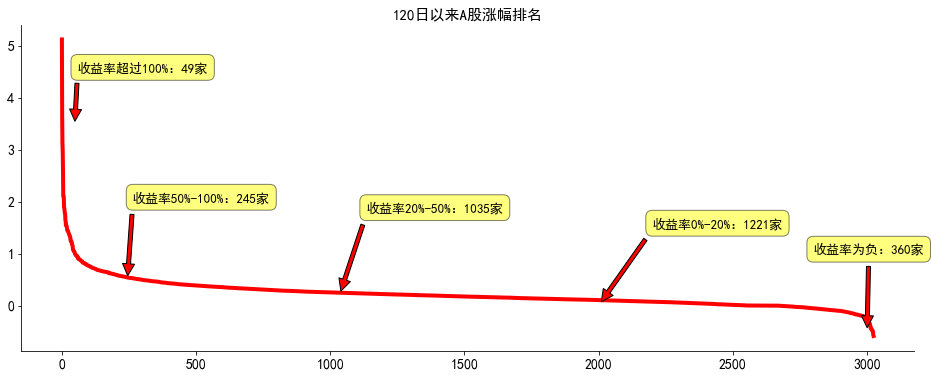

In [15]:
plt.figure(figsize=(16,6))
plt.plot(rps120['20190319']['排名'],rps120['20190319']['收益率'],color='r',linewidth=4)
plt.title('120日以来A股涨幅排名',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# 将右边 上边的两条边颜色设置为空 其实就相当于抹掉这两条边
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   

plt.annotate(f'收益率超过100%：{n1}家',
   xy=(n1,3.5),xytext=(n1+10,4.5), 
   bbox = dict(boxstyle = 'round,pad=0.5',
   fc = 'yellow', alpha = 0.5),
   arrowprops=dict(facecolor='red', 
   shrink=0.05),fontsize=13)

plt.annotate(f'收益率50%-100%：{n2}家',
   xy=(n2,0.5),xytext=(n2+20,2), 
   bbox = dict(boxstyle = 'round,pad=0.5',
   fc = 'yellow', alpha = 0.5),
   arrowprops=dict(facecolor='red', 
   shrink=0.05),fontsize=13)

plt.annotate(f'收益率20%-50%：{n3}家',
   xy=(n3,0.2),xytext=(n3+100,1.8), 
   bbox = dict(boxstyle = 'round,pad=0.5',
   fc = 'yellow', alpha = 0.5),
   arrowprops=dict(facecolor='red', 
   shrink=0.05),fontsize=13)

plt.annotate(f'收益率0%-20%：{n4}家',
   xy=(2000,0),xytext=(2200,1.5), 
   bbox = dict(boxstyle = 'round,pad=0.5',
   fc = 'yellow', alpha = 0.5),
   arrowprops=dict(facecolor='red', 
   shrink=0.05),fontsize=13)

plt.annotate(f'收益率为负：{n5}家',
   xy=(3000,-0.5),xytext=(2800,1), 
   bbox = dict(boxstyle = 'round,pad=0.5',
   fc = 'yellow', alpha = 0.5),
   arrowprops=dict(facecolor='red', 
   shrink=0.05),fontsize=13)


plt.show()

In [16]:
#获取数据函数
import tushare as ts
def get_index(code,start_date='2015-09-1'):
    df=ts.get_k_data(code,start_date)
    df.index=pd.to_datetime(df.date)
    return df.close
indexs={'sh':'上证综指','sz':'深证综指','hs300':'沪深300','sz50':'上证50','zxb':'中小板','cyb':'创业板'}
df_index=pd.DataFrame()
for code,name in indexs.items():
    df_index[name]=get_index(code)

In [17]:
def plot_index(data,day):
    ret=(data/data.shift(day)-1)[day:]
    ret.plot(figsize=(16,6))
    plt.legend(loc=2)
    plt.title(f'A股指数{day}日收益率',fontsize=15)
    ax = plt.gca()  
    ax.spines['right'].set_color('none') 
    ax.spines['top'].set_color('none')
    plt.show()

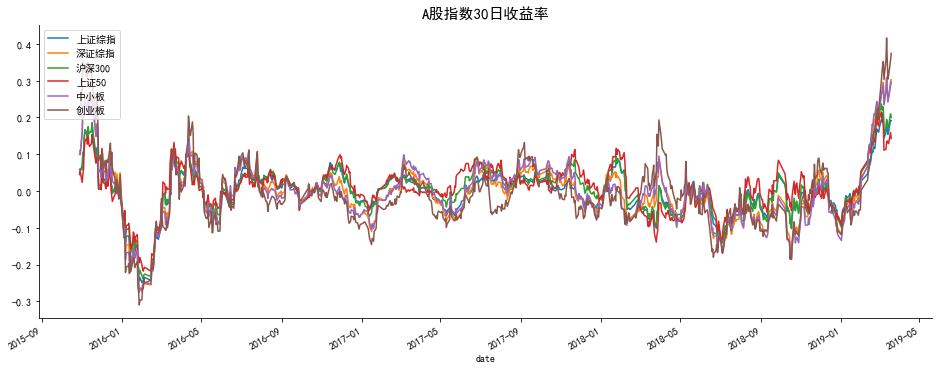

In [18]:
plot_index(df_index,30)

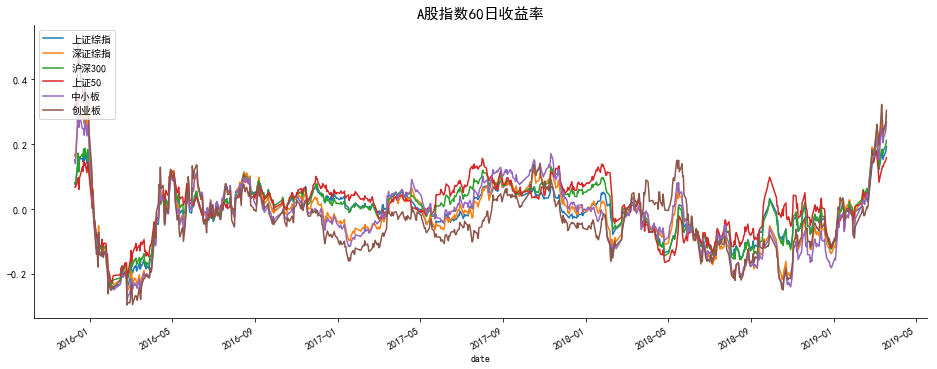

In [19]:
plot_index(df_index,60)

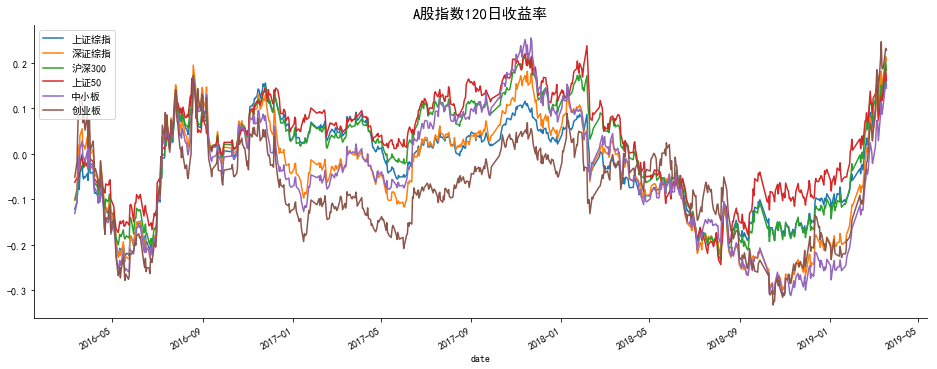

In [20]:
plot_index(df_index,120)

In [21]:
(df_index/df_index.shift(120)-1)[120:].iloc[-1]

上证综指     0.150526
深证综指     0.205295
沪深300    0.184575
上证50     0.162128
中小板      0.144443
创业板      0.228272
Name: 2019-03-19 00:00:00, dtype: float64

In [67]:
from pyecharts import Bar
attr = rps120['20190319'][:10].index
v1 = (rps120['20190319'][:10]['收益率'].values).round(2)*100

bar = Bar("120日以来涨幅前10名",title_text_size=15,title_pos='center')
bar.add("", attr, v1, is_label_show=True,is_splitline_show=False,
       label_formatter='{c}%',is_yaxis_show=False,label_text_size=13,
       is_random=True,label_text_color='black')
bar

In [68]:
from pyecharts import Bar
attr = df1['收益率'].sort_values().index[:10]
v=-(df1['收益率'].sort_values().values[:10])
v=[round(x*100,2) for x in v]

bar = Bar("120日以来涨幅后10名",title_text_size=15,title_pos='center')
bar.add("", attr,v, is_label_show=True,is_splitline_show=False,
       label_formatter='-{c}%',is_yaxis_show=False,label_text_size=13,
       is_random=True,label_text_color='black')

bar

In [76]:
#获取所有股票在某个期间的RPS值
def all_data(rps,ret):
    df=pd.DataFrame(np.NaN,columns=ret.columns,index=ret.index)
    for date in ret.index:
        date=date.strftime('%Y%m%d')
        d=rps[date]
        for c in d.index:
            df.loc[date,c]=d.loc[c,'RPS']
    return df

In [77]:
#构建一个以前面收益率为基础的空表
df_new=pd.DataFrame(np.NaN,columns=ret120.columns,index=ret120.index)

In [78]:
for date in df_new.index:
    date=date.strftime('%Y%m%d')
    d=rps120[date]
    for c in d.index:
        df_new.loc[date,c]=d.loc[c,'RPS']

In [79]:
df_new.head()

平安银行        万科A       国农科技       世纪星源       深振业A        全新好  \
trade_date                                                                     
2018-07-03  19.146825  36.607143  66.898148  27.182540  80.092593  79.761905   
2018-07-04  25.033069  39.583333  60.978836  33.333333  86.574074  86.474868   
2018-07-05  29.398148  41.898148  67.162698  34.027778  84.424603  85.052910   
2018-07-06  30.059524  34.060847  67.394180  32.308201  85.152116  85.218254   
2018-07-09  37.665344  30.753968  65.112434  30.059524  81.250000  81.712963   

                 神州高铁       中国宝安       美丽生态       深物业A    ...           兆易创新  \
trade_date                                                ...                  
2018-07-03  80.687831  25.000000  37.235450  15.773810    ...      79.695767   
2018-07-04  86.210317  24.966931  41.335979  22.023810    ...      87.169312   
2018-07-05  84.953704  23.478836  44.444444  18.253968    ...      83.796296   
2018-07-06  85.350529  24.173280  42.857143  14.517196    ...      85.052910   
2018-07-09  81.349206  26.124339  26.554233  14.219577    ...      81.415344   

                  康德莱      中电电机       艾华集团       麦迪科技       洛阳钼业       中新科技  \
trade_date                                                                    
2018-07-03  63.690476  0.165344   9.953704  74.041005  69.411376  20.469577   
2018-07-04  64.947090  0.132275  10.251323  75.132275  68.551587  25.429894   
2018-07-05  64.847884  0.132275   7.870370  76.421958  59.457672  18.452381   
2018-07-06  67.559524  0.165344   8.134921  75.628307  62.235450  21.263228   
2018-07-09  74.570106  0.231481   9.060847  70.469577  60.019841  24.603175   

                 继峰股份       方盛制药       读者传媒  
trade_date                                   
2018-07-03  79.794974  48.247354  47.685185  
2018-07-04  86.838624  47.850529  50.231481  
2018-07-05  84.193122  29.166667  51.091270  
2018-07-06  84.887566  28.571429  46.726190  
2018-07-09  81.283069  39.120370  48.842593  

[5 rows x 3024 columns]

In [80]:
def plot_rps(stock):
    plt.subplot(211)
    data[stock][120:].plot(figsize=(16,16),color='r')
    plt.title(stock+'股价走势',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks([])
    ax = plt.gca()  
    ax.spines['right'].set_color('none') 
    ax.spines['top'].set_color('none') 
    plt.subplot(212)
    df_new[stock].plot(figsize=(16,8),color='b')
    plt.title(stock+'RPS相对强度',fontsize=15)
    my_ticks = pd.date_range('2018-06-9','2019-3-31',freq='m')
    plt.xticks(my_ticks,fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()  
    ax.spines['right'].set_color('none') 
    ax.spines['top'].set_color('none')
    plt.show()

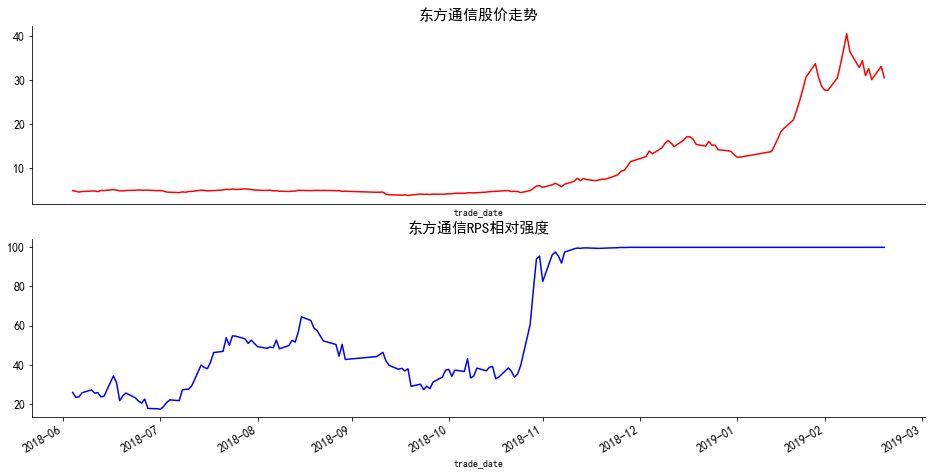

In [81]:
plot_rps('东方通信')

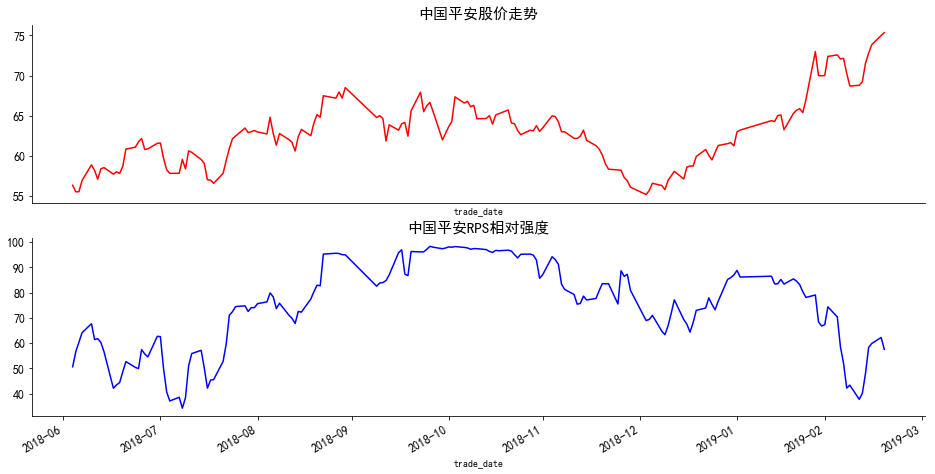

In [82]:
plot_rps('中国平安')

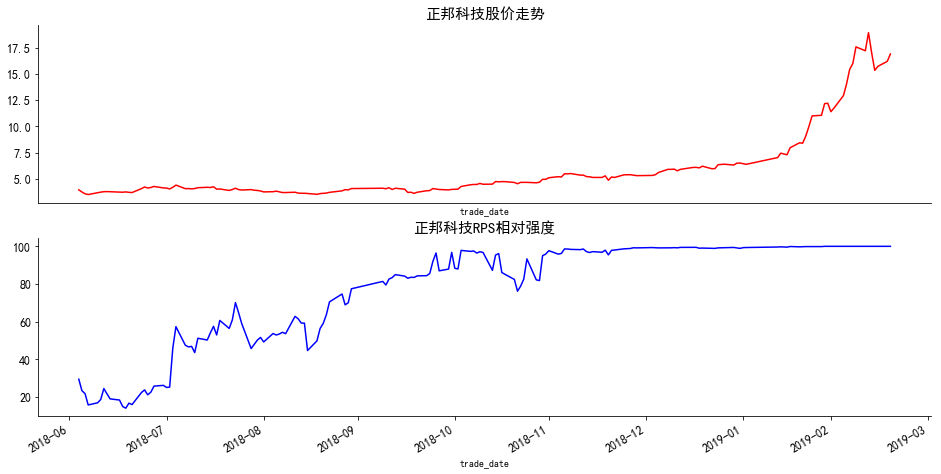

In [83]:
plot_rps('正邦科技')

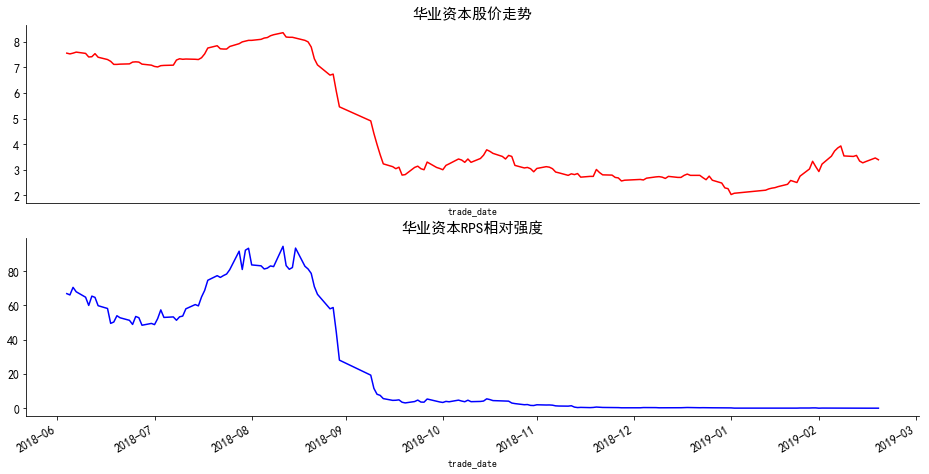

In [84]:
plot_rps('华业资本')

In [85]:
x1=df1['收益率']>0
x2=df1['RPS']>90
x=x1&x2
df1[x].head(10)

收益率    排名        RPS
东方通信   5.122490   1.0  99.966931
正邦科技   3.655647   2.0  99.933862
天邦股份   3.124726   3.0  99.900794
市北高新   2.980247   4.0  99.867725
人民网    2.629389   5.0  99.834656
大智慧    2.103448   6.0  99.801587
*ST凡谷  2.098485   7.0  99.768519
唐人神    2.097345   8.0  99.735450
龙津药业   1.888530   9.0  99.702381
*ST毅达  1.874126  10.0  99.669312

In [86]:
def plot_k_line(stock,start='20181010'):
    from pyecharts import Kline
    d1=pro.daily(ts_code=code_name[stock], start_date=start, fields='trade_date,open,close,low,high')
    d1.index=pd.to_datetime(d1.trade_date)
    d1=d1.sort_index()
    v1=list(d1.loc[:,['open','close','low','high']].values)
    v0=(d1.index).strftime('%y%m%d')
    kline = Kline(stock+"K线图",title_pos='center',title_text_size=15)
    kline.add("", v0, v1,is_datazoom_show=True,mark_line=["average"],
              mark_point=["max", "min"],mark_point_symbolsize=80,
              mark_line_valuedim=['highest', 'lowest'] )
    return kline

In [87]:
plot_k_line("东方通信")

In [88]:
plot_k_line("正邦科技")

In [89]:
plot_k_line("华业资本")

In [90]:
x1=df1['收益率']>0
x2=df1['收益率']<0.50
x3=df1['RPS']>90
x=x1&x2&x3
df1[x]

收益率     排名        RPS
麦迪科技  0.499392  296.0  90.211640
苏州科达  0.498072  297.0  90.178571
上海三毛  0.497685  298.0  90.145503
兆驰股份  0.497630  299.0  90.112434
麦捷科技  0.496324  300.0  90.079365
大连圣亚  0.493842  301.0  90.046296
中核科技  0.493295  302.0  90.013228

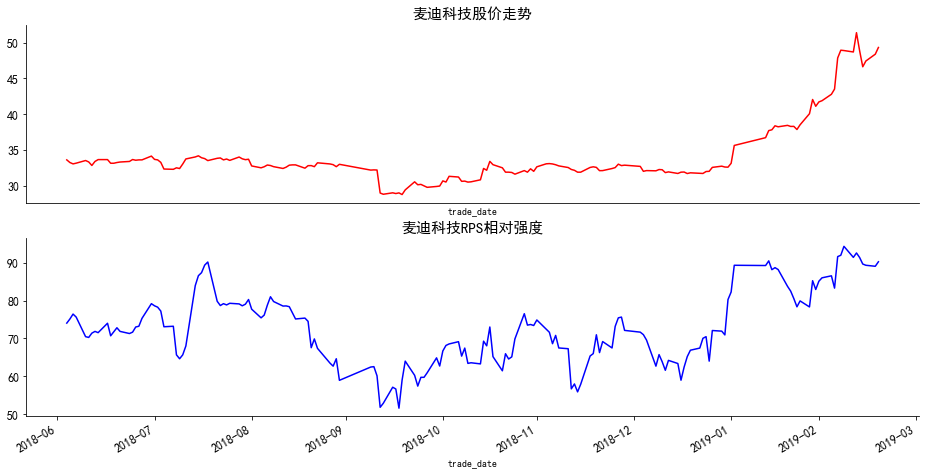

In [91]:
plot_rps('麦迪科技')

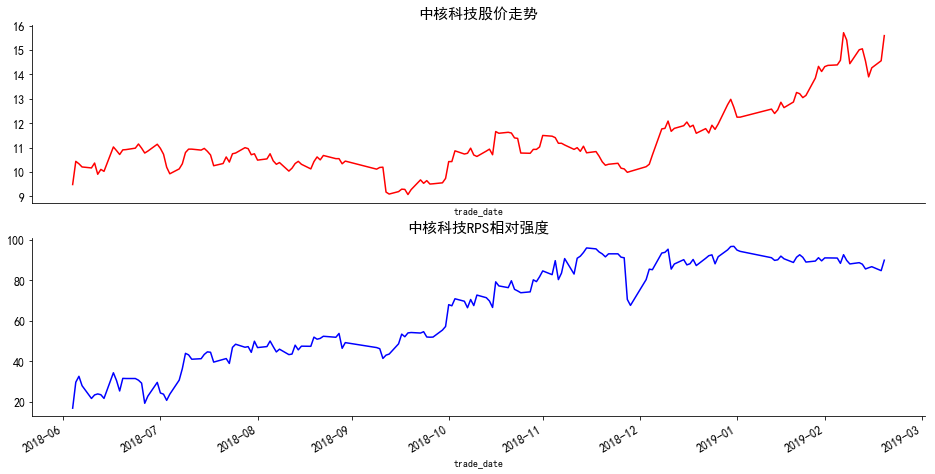

In [92]:
plot_rps('中核科技')

In [138]:
dates=['20180731','20180831','20180928','20181031','20181130','20181228','20190131','20190228','20190319']
df_rps=pd.DataFrame()
for date in dates:
    df_rps[date]=rps120[date].index[:50]

In [139]:
df_rps

20180731 20180831 20180928 20181031 20181130 20181228 20190131 20190228  \
0      顺鑫农业     顺鑫农业     顺鑫农业    *ST尤夫     恒立实业     东方通信     东方通信     东方通信   
1      神马股份     中国软件     神马股份     岷江水电     沪电股份     通产丽星    *ST凡谷     正邦科技   
2      丹邦科技     神马股份     合兴包装     沪电股份     光洋股份     恒立实业    *ST天业    *ST凡谷   
3      风华高科     丹邦科技     中国软件    *ST安泰     鲁信创投    *ST尤夫     ST慧球     天邦股份   
4      新莱应材     青松股份     青松股份     新疆浩源    *ST尤夫     群兴玩具     沪电股份     鲁信创投   
5      中国软件     合兴包装     沪电股份     天孚通信     群兴玩具     ST慧球     天邦股份     风范股份   
6      长亮科技     辰安科技     岷江水电     华测检测    *ST安泰     沪电股份    *ST尤夫     市北高新   
7      泰格医药     ST景谷     智飞生物     华新水泥     朗迪集团     八菱科技     群兴玩具     群兴玩具   
8      天华超净     华新水泥     中油工程     蓝焰控股     市北高新      嘉凯城     雄韬股份     通产丽星   
9      卫宁健康     晓程科技     晓程科技      嘉凯城      奥赛康     珠海中富      新易盛      人民网   
10     北方华创     长亮科技     ST景谷     仁和药业      嘉凯城    *ST天业     ST仰帆     摩恩电气   
11     三联虹普     岷江水电     建新股份     中油工程     新疆浩源     市北高新     隆基股份     雄韬股份   
12      片仔癀     建新股份     古井贡酒     杰瑞股份     珠海中富     天邦股份     通威股份     春兴精工   
13     健帆生物     仁和药业     杰瑞股份     洽洽食品     大连圣亚     高德红外     鲁信创投     华控赛格   
14     通策医疗     太极股份     长春高新     青松股份     民丰特纸     鲁信创投     世嘉科技     ST慧球   
15     万达信息     北方华创     海天味业     中华企业     和仁科技    *ST凡谷     全柴动力     世嘉科技   
16      艾比森     超图软件    *ST安泰     温氏股份     汇嘉时代     光洋股份     杭齿前进     国风塑业   
17     安图生物     健帆生物     华新水泥     创力集团    *ST凡谷    *ST安泰     阳光电源     恒立实业   
18     浪潮信息     卫宁健康     中炬高新     嘉化能源     济民制药     平高电气     平高电气     特发信息   
19     青松股份     益生股份     仁和药业     华兰生物     天孚通信     东信和平     中旗股份     东信和平   
20     仁和药业     航天信息     通源石油     国城矿业      特锐德      特锐德     福建金森     隆基股份   
21     星源材质     安图生物     重庆啤酒     华升股份     丹邦科技     和仁科技     通产丽星      大智慧   
22     中国国旅     长春高新     柳钢股份     萃华珠宝    *ST宜化     华控赛格     正邦科技     全柴动力   
23      广联达      艾比森     新奥股份     顺鑫农业     华新水泥     中兴通讯      柏堡龙    *ST毅达   
24     超图软件     通策医疗     海立股份     美丽生态     凯美特气     新疆浩源     天孚通信     益生股份   
25     华新水泥      白云山     通策医疗     华电国际     中恒电气     南京熊猫     航天通信    *ST天业   
26     华测检测     桃李面包     东方创业     石化机械      中关村     正邦科技     中兴通讯      同花顺   
27      凯莱英     智飞生物     中国国旅      新宙邦     弘业股份     济民制药     恒立实业     牧原股份   
28     晓程科技     沪电股份     丹邦科技     晓程科技     中国软件     通光线缆     东信和平     通威股份   
29     新安股份     风华高科     嘉化能源     三垒股份     汉商集团     冀东水泥     市北高新     顺灏股份   
30     合兴包装     华测检测     新集能源     石基信息     中国铁建     杭齿前进     通光线缆     杭齿前进   
31     柳钢股份     民和股份     江山股份     国海证券     金科股份    *ST宜化     济民制药     银星能源   
32      一心堂     杰瑞股份     上海机场     开滦股份     宝鹰股份     天孚通信     珠海中富     航天通信   
33     建新股份     三联虹普     兰生股份     汇嘉时代     大众公用    *ST船舶     高德红外     福建金森   
34     桃李面包    *ST安泰     中洲控股     中国铁建     平高电气     九鼎投资     鼎信通讯     民和股份   
35     古井贡酒      片仔癀     华兰生物     通源石油     嘉化能源      新易盛     金雷股份     张江高科   
36     宝信软件     浪潮信息     宏大爆破     金科股份      东方通      苏交科     风范股份     光洋股份   
37     创维数字     亚振家居     卫宁健康      特锐德     张江高科     ST岩石     通宇通讯     九鼎投资   
38       柳工      广联达     中国石油     华纺股份     创业慧康     金科股份     万润股份      唐人神   
39     益丰药房     华锋股份     华能国际     马钢股份     中国动力      奥赛康     摩恩电气     平高电气   
40     宋城演艺      海思科      万里扬     合兴包装     佳发教育     张江高科     山东黄金      特锐德   
41     重庆啤酒     石基信息     东北制药     长春燃气     创力集团     裕兴股份    *ST安泰     金证股份   
42     当升科技     古井贡酒      白云山     柳钢股份     华电国际     通威股份     江铃汽车      柏堡龙   
43     华锋股份     东北制药     涪陵榨菜     濮耐股份    *ST因美     万润股份     五洋停车     通光线缆   
44     视觉中国      中海达       柳工     百川能源     杭齿前进     民丰特纸      福斯特     绿庭投资   
45     鲁抗医药     宏大爆破     国城矿业     联化科技     东方钽业     汇嘉时代     华纺股份     广东甘化   
46     海天味业     日机密封      苏泊尔     中国软件     凤凰传媒     高新发展     牧原股份      新希望   
47     ST景谷     三垒股份     民和股份     中恒电气     金花股份      中关村     ST岩石     宏达矿业   
48      中海达     万达信息     海越能源     中国石油      比亚迪     超讯通信     天能重工     金雷股份   
49     海波重科     福建水泥     圣农发展     常宝股份     西部证券     中国铁建     华测检测     高德红外   

   20190319  
0      东方通

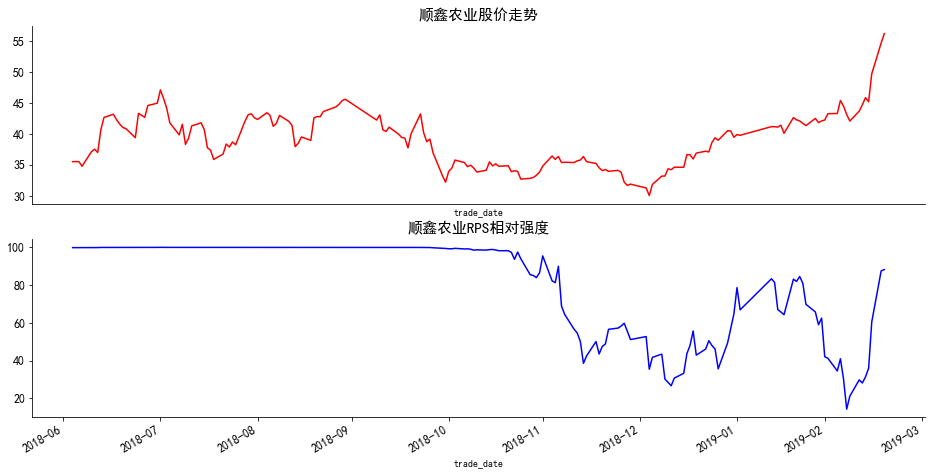

In [140]:
plot_rps('顺鑫农业')

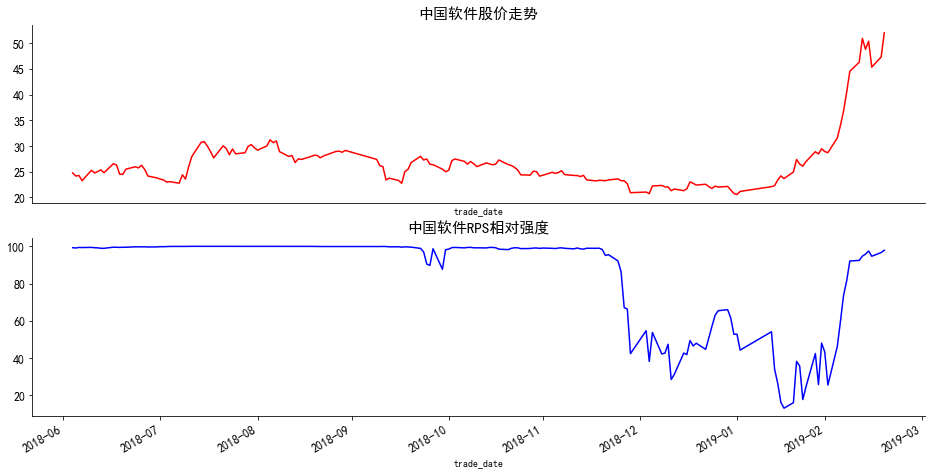

In [141]:
plot_rps('中国软件')